In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('bmh')

In [12]:
import numpy as np

import attr
import os
import click
import torch
import ujson

from scipy import stats
from gensim.models import KeyedVectors
from boltons.iterutils import pairwise, chunked_iter
from tqdm import tqdm_notebook
from glob import glob
from itertools import islice

from sklearn.metrics import classification_report, accuracy_score

from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

In [4]:
vectors = KeyedVectors.load('../data/vectors/vectors.bin')

In [5]:
def read_abstracts(path):
    for path in glob(os.path.join(path, '*.json')):
        with open(path) as fh:
            for line in fh:
                raw = ujson.loads(line.strip())
                yield Abstract.from_raw(raw)

In [6]:
class Corpus:

    def __init__(self, path, skim):
        reader = islice(read_abstracts(path), skim)
        self.abstracts = list(tqdm_notebook(reader, total=skim))

    def batches(self, size):
        for chunk in chunked_iter(tqdm_notebook(self.abstracts), size):
            yield AbstractBatch(chunk)

In [7]:
@attr.s
class Abstract:

    sentences = attr.ib()

    @classmethod
    def from_raw(cls, raw):
        return cls([Sentence(s['token']) for s in raw['sentences']])

    def tensor(self):
        tensors = [s.tensor() for s in self.sentences]
        return torch.stack(tensors)

In [8]:
@attr.s
class Sentence:

    tokens = attr.ib()

    def tensor(self, dim=300, pad=50):
        x = [vectors[t] for t in self.tokens if t in vectors]
        x += [np.zeros(dim)] * pad
        x = x[:pad]
        x = list(reversed(x))
        x = np.array(x)
        x = torch.from_numpy(x)
        x = x.float()
        return x

In [37]:
@attr.s
class AbstractBatch:

    abstracts = attr.ib()

    def tensor(self):
        tensors = [a.tensor() for a in self.abstracts]
        return torch.cat(tensors).type(dtype)
    
    def unpack_encoded_batch(self, batch):
        start = 0
        for ab in self.abstracts:
            yield batch[start:start+len(ab.sentences)]
            start += len(ab.sentences)
            
    def xy(self, batch, maxlen=10):
        for sents in self.unpack_encoded_batch(batch):
            
            if len(sents) >= maxlen:
                continue
                
            shuffle = torch.randperm(len(sents))
            kt, _ = stats.kendalltau(range(len(sents)), shuffle.tolist())
            
#             print(list(range(len(sents))), shuffle.tolist(), kt)
            
            zeros = Variable(torch.zeros(maxlen-len(sents), sents.data.shape[1]))
            shuffled_sents = sents[shuffle]
            
            yield torch.cat([zeros, sents]), Variable(torch.FloatTensor([1]))
            yield torch.cat([zeros, shuffled_sents]), Variable(torch.FloatTensor([kt]))

In [38]:
class SentenceEncoder(nn.Module):

    def __init__(self, lstm_dim=128):
        super().__init__()
        self.lstm_dim = lstm_dim
        self.lstm = nn.LSTM(300, lstm_dim, batch_first=True)

    def forward(self, x):
        h0 = Variable(torch.zeros(1, len(x), self.lstm_dim).type(dtype))
        c0 = Variable(torch.zeros(1, len(x), self.lstm_dim).type(dtype))
        _, (hn, cn) = self.lstm(x, (h0, c0))
        return hn

In [39]:
class Model(nn.Module):

    def __init__(self, input_dim=128, lstm_dim=128):
        super().__init__()
        self.lstm_dim = lstm_dim
        self.lstm = nn.LSTM(input_dim, lstm_dim, batch_first=True)
        self.out = nn.Linear(lstm_dim, 1)

    def forward(self, x):
        h0 = Variable(torch.zeros(1, len(x), self.lstm_dim).type(dtype))
        c0 = Variable(torch.zeros(1, len(x), self.lstm_dim).type(dtype))
        _, (hn, cn) = self.lstm(x, (h0, c0))
        y = self.out(hn)
        return y.view(len(x))

In [40]:
train = Corpus('../data/train.json/', 1000)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

In [41]:
torch.manual_seed(1)

sent_encoder = SentenceEncoder()
model = Model()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [44]:
train_loss = []
for epoch in range(20):
    
    print(f'Epoch {epoch}')
    
    epoch_loss = 0
    for batch in train.batches(50):

        sents = Variable(batch.tensor())
        sents = sent_encoder(sents)

        x, y = zip(*batch.xy(sents.squeeze()))

        x = torch.stack(x)
        y = torch.stack(y).view(-1)

        y_pred = model(x)

        loss = criterion(y_pred, y)
        loss.backward()

        optimizer.step()
        
        epoch_loss += loss.data[0]
        
    epoch_loss /= len(train.abstracts)
    train_loss.append(epoch_loss)
    print(epoch_loss)

Epoch 0


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

/Users/dclure/Projects/plot-ordering/env/lib/python3.6/site-packages/scipy/stats/stats.py:3559: RuntimeWarning: invalid value encountered in double_scalars
  size * (size - 1) * (size - 2))



0.008189398795366287
Epoch 1


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


0.008595637202262878
Epoch 2


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


0.008477841615676879
Epoch 3


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


0.007920845806598664
Epoch 4


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


0.00810914632678032
Epoch 5


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


0.007632412880659104
Epoch 6


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


0.007991859674453735
Epoch 7


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


0.0077432159781456
Epoch 8


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


0.007874375939369202
Epoch 9


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


0.007940938383340836
Epoch 10


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


0.007936264961957932
Epoch 11


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

KeyboardInterrupt: 

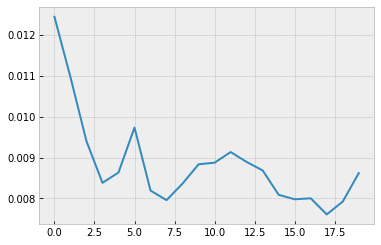

In [43]:
plt.plot(train_loss)